In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(10)

# **Resampling**

# **Section 1: Regression (abalone age)**

## Question 1

In [100]:
data=pd.read_csv('HWs/HW4/Files/homework-4/data/abalone.csv')

In [101]:
# Create target variable age from rings
data['age'] = data['rings'] + 1.5
# Dummy encode gender variable
data = pd.get_dummies(data, columns=['type'],dtype=int, drop_first=True)
# Create interation terms
data['shucked_weight*longest_shell'] = data['shucked_weight'] * data['longest_shell']
data['longest_shell*diamter'] = data['longest_shell'] * data['diameter']
data['shucked_weight*shell_weight'] = data['shucked_weight'] * data['shell_weight']

# Scale data
scaler = StandardScaler()
scaled_array = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_array, columns = data.columns)
scaled_data.head()

# Create test/train splits of data
X = data.drop(['rings','age'], axis=1)
Y = data['age']
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=.25
)

# Setup 5-fold cross-validation for training set
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True)

X_train_splits_CV, Y_train_splits_CV = ([], [])
X_test_splits_CV, Y_test_splits_CV = ([], [])

X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)

indices = []
for train_index, test_index in kf.split(X_train):
    indices.append((train_index, test_index))

print(f"Size of training splits: {len(indices[0][0])}")
print(f"Size of testing splits: {len(indices[0][1])}")

Size of training splits: 2505
Size of testing splits: 627


## Question 2

- k-fold cross validation is a resampling method used to approximate testing error without an actual test data-set. Specifically, k-fold CV is when the testing data is split randomly into k equally sized folds. For each fold f, the other k-1 folds are used to train the model, which is then evaluated on fold f. This is repeated for each fold an the average of the k "test" errors is the final result.
  
- k-fold CV should be used in place of the error of fitting the model on the entire training set since it is not useful to examine results for which the model has been trained on. If we only looked at training set error, the most flexible model would perform best. However, this would be a very poor estimate of the error that would be observed on a real test set. Instead, k-fold CV provides a better alternative since the model is evaluated on data that it was not trained on.
  
- "If we split the training set into two and used one of those two splitsto evaluate/compare our models, what resampling method would webe using?" This is an example of a basic 50/50 validation set approach.

## Questions 3 / 4

There are 10 parameters for knn and 5 folds -> 50 models  
There is only a single linear regression model and 5 folds -> 5 models  
There are 10*10 parameter combinations for EN and 5 folds -> 500 models  
**Total Models Fit: 555**

In [102]:
params_knn = {'n_neighbors': [i for i in range(1,11)]}
params_elastic_net = {
    'l1_ratio': np.arange(0,1.01,1/9), 
    'alpha': [i*.2 for i in range(1,11)]}

In [103]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

knn = KNeighborsRegressor()
grid_knn = GridSearchCV(
    estimator = knn,
    param_grid = params_knn,
    scoring='neg_mean_squared_error',
    cv=indices,
    verbose=1).fit(X_train,Y_train)

lr = LinearRegression()
lr_cv = cross_val_score(
    estimator=lr,
    X=X_train,
    y=Y_train,
    cv=indices,
    scoring='neg_mean_squared_error')

en = ElasticNet(tol=1e-3,max_iter=5000)
grid_en = GridSearchCV(
    estimator=en,
    param_grid=params_elastic_net,
    scoring='neg_mean_squared_error',
    cv=indices,
    verbose=1).fit(X_train,Y_train)

sd_lr = []
for train_index, test_index in indices:
    lr.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
    predictions = lr.predict(X_train.iloc[test_index])
    resid = Y_train.iloc[test_index] - predictions
    sd_lr.append(np.std(resid, ddof=1))

mean_sd_lr = np.mean(sd_lr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


## Question 5

While the linear regression model had the lowest validaiton error, it had significantly higher standard error of residuals than the best KNN model, which performed almost as well on an RMSE basis. Thus, we conclude that the k=9 KNN model performed the best.

In [104]:
print(f"Best KNN model: {grid_knn.best_estimator_}")
print(f"     RMSE: {round(np.sqrt(-grid_knn.best_score_),2)}, SE: {round(grid_knn.cv_results_['std_test_score'][grid_knn.best_index_],4)}")
print("")
print(f"Linear Regression Cross-Val Results:")
print(f'      RMSE: {round(np.sqrt(-np.mean(lr_cv)),2)}, SE: {round(mean_sd_lr,4)}')
print('')
print(f"Best EN model: {grid_en.best_estimator_}")
print(f"     RMSE: {round(np.sqrt(-grid_en.best_score_),2)}, SE: {round(grid_en.cv_results_['std_test_score'][grid_en.best_index_],4)}")

Best KNN model: KNeighborsRegressor(n_neighbors=9)
     RMSE: 2.23, SE: 0.3603

Linear Regression Cross-Val Results:
      RMSE: 2.17, SE: 2.1722

Best EN model: ElasticNet(alpha=0.2, l1_ratio=1.0, max_iter=5000, tol=0.001)
     RMSE: 2.73, SE: 0.7445


## Question 6

In [105]:
from sklearn.metrics import mean_squared_error

knn = grid_knn.best_estimator_.fit(X_train,Y_train)
lr = lr.fit(X_train,Y_train)
en = grid_en.best_estimator_.fit(X_train,Y_train)

mse_knn = mean_squared_error(knn.predict(X_test), Y_test)
mse_lr = mean_squared_error(lr.predict(X_test), Y_test)
mse_en = mean_squared_error(en.predict(X_test), Y_test)

In [106]:
CV_scores = {'knn': np.sqrt(-grid_knn.best_score_),
             'lr': np.sqrt(-np.mean(lr_cv)),
             'EN': np.sqrt(-grid_en.best_score_)}

test_scores = {'knn': np.sqrt(mse_knn),
             'lr': np.sqrt(mse_lr),
             'EN': np.sqrt(mse_en)}

pd.DataFrame([CV_scores, test_scores], index = ['CV Scores', 'test_scores'])

,knn,lr,EN
CV Scores,2.232662,2.173269,2.734710
test_scores,2.154330,2.151551,2.629412


We can see that the CV validation error was a very good proxy for actual test error!

# Section 2: Classification (Titanic survival)

## Question 7

In [157]:
data = pd.read_csv('HWs/HW4/Files/homework-4/data/titanic.csv')

from sklearn.model_selection import train_test_split
np.random.seed(10)

X = data.drop('survived', axis=1)
Y = data['survived']
Y = pd.DataFrame(Y.replace({'Yes':1,'No':0}))

# Perform the same data modifications as for HW3
X.drop(['passenger_id', 'name', 'ticket', 'cabin', 'embarked'], axis=1, inplace=True)
X['age'] = X['age'].interpolate(method='linear')
X = pd.get_dummies(X, columns=['pclass', 'sex'], dtype=int, drop_first=True)
X['sex_male*fare'] = X['sex_male'] * X['fare']
X['age*fare'] = X['age'] * X['fare']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

X_scaled.columns = X.columns

x_train, x_test, y_train, y_test = train_test_split(X_scaled,Y, train_size=.7, stratify=Y)

In [158]:
kf = KFold(n_splits=5, shuffle=True)

x_train_sets_CV, y_train_sets_CV = ([],[])
x_test_sets_CV, y_test_sets_CV = ([],[])

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

for train_index, test_index in kf.split(x_train):
    x_train_sets_CV.append(x_train.iloc[train_index])
    y_train_sets_CV.append(y_train.iloc[train_index])
    x_test_sets_CV.append(x_train.iloc[test_index])
    y_test_sets_CV.append(y_train.iloc[test_index])

print(f"Size of CV training sets: {len(x_train_sets_CV[0])}")
print(f"Size of CV testing sets: {len(x_test_sets_CV[0])}")

Size of CV training sets: 498
Size of CV testing sets: 125


## Question 8 / 9 / 10

#### Here we upsample the minority class in each fold.

In [116]:
params_knn = {'n_neighbors': [i for i in range(1,11)]}
params_elastic_net = {
    'l1_ratio': np.arange(0,1.01,1/9),
    'C': [.2*j for j in range(1,11)]}

In [161]:
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

cv_results_knn, cv_results_en = ([],[])
lr_roc = []

for j, val in enumerate(x_train_sets_CV):
    x_majority = val.loc[y_train_sets_CV[j][y_train_sets_CV[j] == 0].dropna().index]
    y_majority = y_train_sets_CV[j][y_train_sets_CV[j] == 0].dropna()

    x_minority = val.loc[y_train_sets_CV[j][y_train_sets_CV[j] == 1].dropna().index]
    y_minority = y_train_sets_CV[j][y_train_sets_CV[j] == 1].dropna()
    
    x_minority_upsampled, y_minority_upsampled = resample(
        x_minority,
        y_minority,
        replace=True,
        n_samples=x_majority.shape[0],
    )

    x_train_upsampled = pd.concat([x_majority, x_minority_upsampled])
    y_train_upsampled = pd.concat([y_majority, y_minority_upsampled])

    x_train_sets_CV[j] = x_train_upsampled
    y_train_sets_CV[j] = y_train_upsampled

Then, a manual grid search is performed, since 'GridSearchCV' cannot handle our upsampled data.

In [162]:
# Encode outcome to binary for ROC curve metric

# Fit the knn models w/ k = 1:10
for params in ParameterGrid(params_knn):
    cv_results_knn_fold = []
    for j in range(5):
        model = KNeighborsClassifier(**params)
        model.fit(x_train_sets_CV[j], y_train_sets_CV[j])
        predictions = model.predict(x_test_sets_CV[j])
        roc = roc_auc_score(predictions, y_test_sets_CV[j])
        # Store the results
        cv_results_knn_fold.append(roc)
    cv_results_knn.append({'paramters': params, 
                            'area_under_ROC':np.mean(cv_results_knn_fold)})

# Fit the EN models w/ l1_ratio in .1:1 and alpha in .2:2
for params in ParameterGrid(params_elastic_net):
    cv_results_en_fold = []
    for j in range(5):
        model = LogisticRegression(penalty='elasticnet',solver='saga',max_iter=5000,tol=1e-3,**params)
        model.fit(x_train_sets_CV[j], y_train_sets_CV[j])
        predictions = model.predict(x_test_sets_CV[j])
        roc = roc_auc_score(predictions, y_test_sets_CV[j])
        # Store the results
        cv_results_en_fold.append(roc)      
    cv_results_en.append({'paramters': params, 
                            'area_under_ROC':np.mean(cv_results_en_fold)})

# Fit the linear model for each fold
for j in range(5):
    model = LogisticRegression().fit(x_train_sets_CV[j], y_train_sets_CV[j])
    predictions = model.predict(x_test_sets_CV[j])
    lr_roc.append(roc_auc_score(predictions, y_test_sets_CV[j]))

## Question 11

In [163]:
print("########## KNN ##########")
print(f"Average AUROC: {np.mean([d['area_under_ROC'] for d in cv_results_knn])}")
print(f"Average std of AUROC results: {np.std([d['area_under_ROC'] for d in cv_results_knn])}")
print(f"Best model: {cv_results_knn[[d['area_under_ROC'] for d in cv_results_knn].index(max([d['area_under_ROC'] for d in cv_results_knn]))]}")
print('')
print('########## EN ##########')
print(f"Average AUROC: {np.mean([d['area_under_ROC'] for d in cv_results_en])}")
print(f"Average std of AUROC results: {np.std([d['area_under_ROC'] for d in cv_results_en])}")
print(f"Best model: {cv_results_en[[d['area_under_ROC'] for d in cv_results_en].index(max([d['area_under_ROC'] for d in cv_results_en]))]}")
print('')
print('##### Logistic Regression #####')
print(f"Average AUROC: {np.mean(lr_roc)}")
print(f"Average std of AUROC results: {np.std(lr_roc)}")
print(f"Best model: N/A, no hyper-parameters")

########## KNN ##########
Average AUROC: 0.7737723598742522
Average std of AUROC results: 0.014645252041560333
Best model: {'paramters': {'n_neighbors': 8}, 'area_under_ROC': 0.7913642807541821}

########## EN ##########
Average AUROC: 0.7641605782902401
Average std of AUROC results: 0.002260049487136677
Best model: {'paramters': {'C': 0.2, 'l1_ratio': 0.8888888888888888}, 'area_under_ROC': 0.7685216903070776}

##### Logistic Regression #####
Average AUROC: 0.7669419124221886
Average std of AUROC results: 0.037714211914069797
Best model: N/A, no hyper-parameters


#### We can see that the KNN (k=8) model performed best based on the AORC metric. It did have a higher std of AORC than the EN models, but still was not significant relative to the result. Hence, we choose KNN (k=8) as the best performing model based on its average 5-fold validation set error.

## Question 12

### Fit data to entire training and testing sets

In [165]:
from sklearn.metrics import mean_squared_error

# Must encode outcome as binary to use roc_auc_score
y_train = y_train.replace({'Yes':1, 'No':0})

knn = KNeighborsClassifier(n_neighbors=8).fit(x_train,y_train)
lr = LogisticRegression().fit(x_train,y_train)
en = LogisticRegression(penalty='elasticnet', C=.2, l1_ratio=0.8888888888888888, max_iter=5000, tol=1e-3, solver='saga').fit(x_train,y_train)


train_auroc = {'KNN':roc_auc_score(knn.predict(x_train), y_train),
             'EN': roc_auc_score(en.predict(x_train), y_train),
             'Logistic Regression': roc_auc_score(lr.predict(x_train), y_train)}

k_fold_auroc = {'KNN': np.mean([d['area_under_ROC'] for d in cv_results_knn]),
                'EN': np.mean([d['area_under_ROC'] for d in cv_results_en]),
                'Logistic Regression': np.mean(lr_roc)}

test_auroc = {'KNN': roc_auc_score(knn.predict(x_test), y_test),
            'EN': roc_auc_score(en.predict(x_test), y_test),
            'Logistic Regression': roc_auc_score(lr.predict(x_test), y_test)}

pd.DataFrame([train_auroc,k_fold_auroc,test_auroc], index=['Training Set AUROC', 'Average 5-fold CV AUROC', 'Testing Set AUROC'])

,KNN,EN,Logistic Regression
Training Set AUROC,0.858904,0.787364,0.786952
Average 5-fold CV AUROC,0.773772,0.764161,0.766942
Testing Set AUROC,0.781313,0.757358,0.739267


#### We can see that KNN (k=8) performed best on the validation set AUROC curve as well as on the testing set, as we would expect since the validation set serves an estimate to true test error.

## Question 13

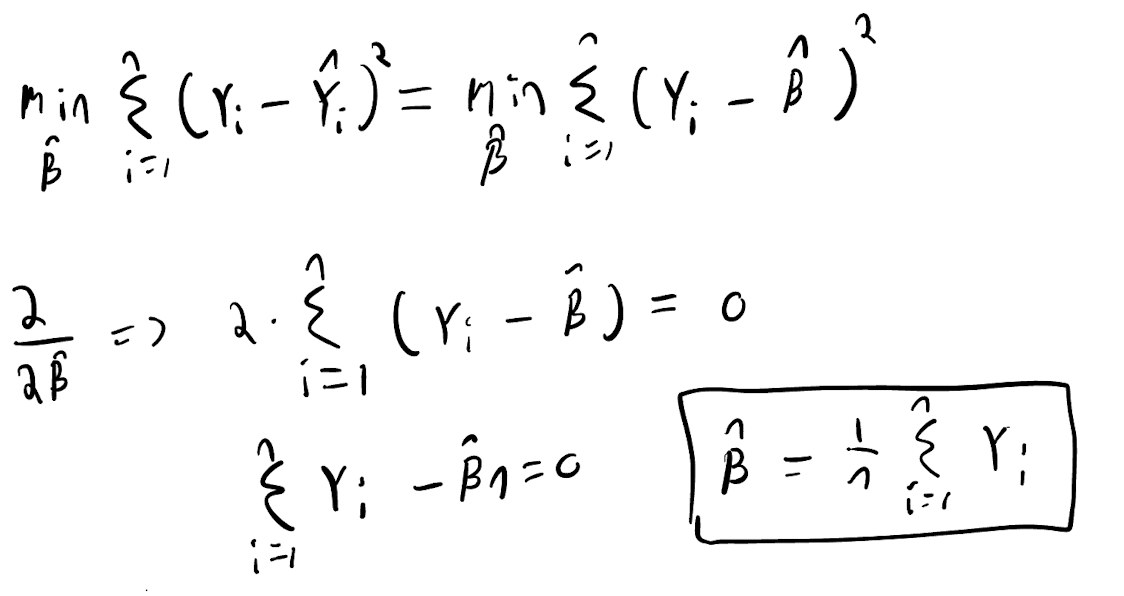

## Question 14

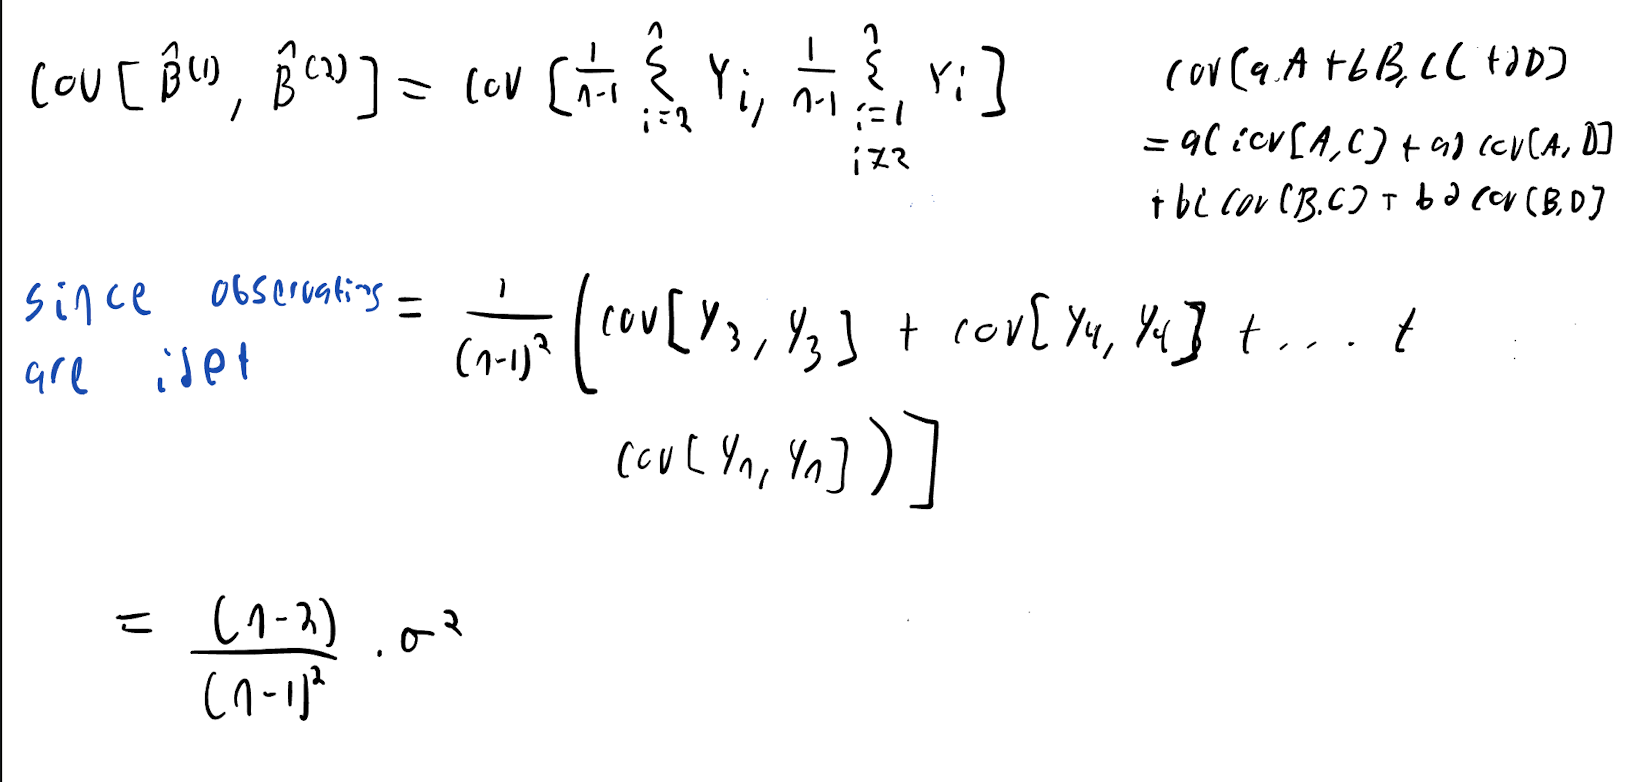